In [1]:
import numpy as np
from numba import jit,njit
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
from scipy import sparse
import skimage
import tifffile as tiff
import os
import math
import operator
from com import *
from skeleton import *
from tqdm import tqdm

In [2]:
imgspath = r"/home/isis0517/temp_data"
#imgspath = "/home/isis0517/Documents/data/imgs"

def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(imgspath)
flist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(flist))
data_len = len(flist)//2


80000


(500, 2000)


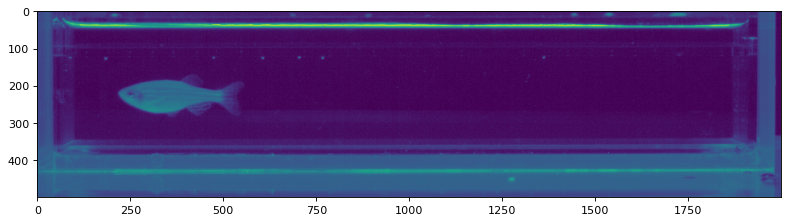

In [3]:
test_frame = np.load(os.path.join(imgspath, flist[60]))
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(test_frame)
print(test_frame.shape)

In [4]:
# video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (1200,800))
# for s in tqdm(range(data_len)):
    
#     b = cv2.resize(np.flip(np.load(os.path.join(imgspath, flist[s+data_len]))), (1200,400))
#     b = cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
#     a = cv2.resize(a, (1200,400))
#     video.write(np.concatenate((b, a), axis=0))
# video.release()
# plt.imshow(a)


In [10]:
# tnum = np.random.randint(data_len,size = int(data_len*0.2))
# a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
# back = np.zeros(a.shape)
# for s in tnum:
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
#     back += a
# back = back/len(tnum)
# back = back.astype('uint8')

In [11]:
# video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (a.shape[1], a.shape[0]), True)
# kernel = np.ones((3,3), np.uint8)
# for s in tqdm(range(data_len)):
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
#     diff = ((cv2.absdiff(a, back)>30)*255).astype('uint8')
    
#     diff = cv2.erode(diff, kernel, iterations = 4)
#     diff = cv2.dilate(diff, kernel, iterations = 6)
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
#     video.write(cv2.bitwise_and(a, a, mask = diff)) #apply mask
    
# video.release()

    
# diff = cv2.dilate(diff, kernel, iterations = 3)
# plt.imshow(diff)
# #cv2.imwrite("test.png", diff)

In [12]:
# labels = label(diff, connectivity=2, background=0)
# group = regionprops(labels, cache=True)

# 找出ZebraPCA

## 產生背景

In [5]:
tnum = np.random.randint(data_len,size = 1000)
a = np.load(os.path.join(imgspath, flist[10+data_len]))
background = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s+data_len]))
    a = cv2.blur(a, ksize=(3, 3))
    background += a
background = background/len(tnum)
background = background.astype('uint8')


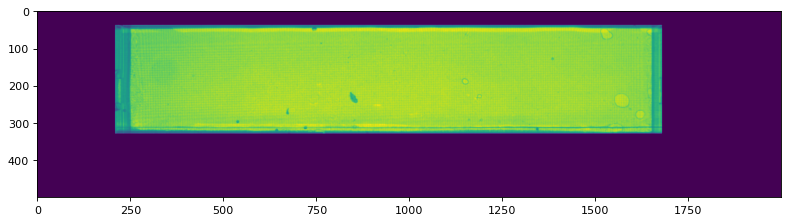

In [6]:
mask = np.full(background.shape, False)
mask[40:330,210:1680]=True
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(background*mask)

## 轉正圖片 & 儲存

In [ ]:
abs_lim = 50

In [ ]:
# imgs = []
# h_ans = []

# for s in tqdm(range(data_len)):
    
#     img = np.load(os.path.join(imgspath, flist[s+data_len]))
#     img = cv2.absdiff(img, background)
#     img = img*mask
#     img = np.where(img>abs_lim, 255, 0).astype('uint8')
#     pos = get_pos(img)
#     img = cutting_img(img, pos, 100)
#     try:
#         sk = NT_skeleton(img)
#     except Exception as e:
#         print(s, e)
#         continue
        
#     v1 = sk[0]-sk[2]
#     a = v1/np.linalg.norm(v1, ord=2)
#     b = np.array([1,0])
#     c = a-b
#     angle = 2*np.arcsin(np.linalg.norm(c/2))
#     if a[1]>0:
#         angle = -angle
#     if angle != angle:
#         print("算錯啦")
#         print(sk)
#     M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
#     rotated = cv2.warpAffine(img, M, (201,201))
    
#     imgs.append(rotated)
#     h_ans.append(angle)

### multi ver

In [ ]:
# %%time
# from multiprocessing import Pool
# from numba import jit, njit

# def multi_cle_img(filename, background, mask, abs_lim):
#     img = np.load(filename)
#     img = cv2.absdiff(img, background)
#     img = img*mask
#     img = np.where(img>abs_lim, 255, 0).astype('uint8')
#     pos = get_pos(img)
#     img = cutting_img(img, pos, 100)
#     return img

# map_arr = []

# with Pool() as pool:
#     map_arr = []
#     for s in range(data_len):
#         path = os.path.join(imgspath, flist[s+data_len])
#         map_arr.append((path, background, mask, abs_lim))
#     print("pool start")
#     result = pool.starmap(multi_cle_img, map_arr)
# temp_imgs = result



In [ ]:

# def multi_ans(img):
#     try:
#         sk = NT_skeleton(img)
#     except Exception as e:
#         print(s, e)
#         return 0
        
#     v1 = sk[0]-sk[2]
#     a = v1/np.linalg.norm(v1, ord=2)
#     b = np.array([1,0])
#     c = a-b
#     angle = 2*np.arcsin(np.linalg.norm(c/2))
#     if a[1]>0:
#         angle = -angle
#     if angle != angle:
#         print("算錯啦")
#         print(sk)
#     return angle

# with Pool() as pool:
#     print("pool start")
#     result = pool.map(multi_ans, temp_imgs)
# h_ans = result
# print("end")
# imgs = []
# #h_ans = []

# def multi_rot_img(img, angle):
#     M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
#     rotated = cv2.warpAffine(img, M, (201,201))
#     return img

# with Pool() as pool:
#     map_arr = []
#     for s in range(len(h_ans)):
#         map_arr.append((temp_imgs[s], h_ans[s]))
#     print("pool start")
#     result = pool.starmap(multi_rot_img, map_arr)


In [7]:
%%time
from multiprocessing import Pool
from numba import jit, njit

abs_lim = 50
def multi_rot_imgs(filename, background, mask, abs_lim):
    size = 120
    img = np.load(filename)
    img = cv2.absdiff(img, background)
    img = img*mask
    img = np.where(img>abs_lim, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, size)
    
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        return 0
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((size, size), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (2*size+1,2*size+1))
    
    return rotated, angle


with Pool() as pool:
    map_arr = []
    for s in range(data_len):
        path = os.path.join(imgspath, flist[s+data_len])
        map_arr.append((path, background, mask, abs_lim))
    print("pool start")
    result = pool.starmap(multi_rot_imgs, map_arr)
print(result[0])

pool start
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), -1.4858945333451745)
CPU times: user 2.64 s, sys: 2.52 s, total: 5.15 s
Wall time: 3min 3s


In [8]:
imgs = []
h_ans = []

for temp in result:
    imgs.append(temp[0])
    h_ans.append(temp[1])

1.136842957401


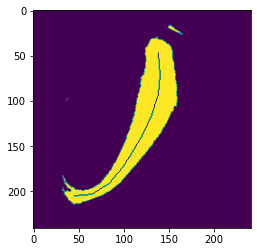

In [9]:
s = 701 
sk = NT_skeleton(imgs[s])

print(h_ans[s])
draw = imgs[s].copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

### save as video

In [13]:
video = cv2.VideoWriter("output_v.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (imgs[0].shape[1], imgs[0].shape[0]), False)

for s, img in enumerate(tqdm(imgs)):
    try :
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
    draw = img.copy()
    for n in range(len(sk)-1):
        cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
    video.write(draw)
video.release()

  1%|▏         | 514/40000 [00:04<05:32, 118.73it/s]


KeyboardInterrupt: 

## apply the eigenfish

  5%|▌         | 2180/40000 [00:19<05:22, 117.22it/s]

2186 [[ 40 133]
 [122 132]
 [185  83]
 [208  47]
 [209  46]
 [210  45]
 [208  47]]


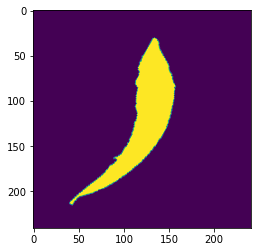

  7%|▋         | 2656/40000 [00:23<05:30, 112.95it/s]


KeyboardInterrupt: 

In [10]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)



han_sks=[]

for s, img in enumerate(tqdm(imgs)):
    
    sk = NT_skeleton(img)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print(s, NT_skeleton(imgs[s]))
        plt.show()
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    n+=1
    han_sks.append(han_sk)
print(len(han_sks))    


## 20000張 1:25

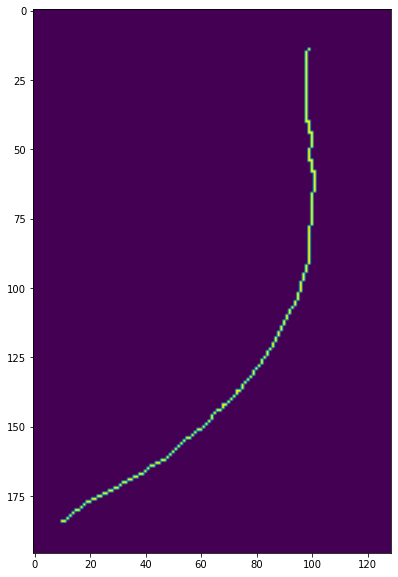

head: (184, 10);271, end: (14, 99);376, fishlen = 220.38999999999973
[[ 39 134]
 [ 64 133]
 [ 86 136]
 [110 134]
 [132 128]
 [152 117]
 [170 100]
 [186  83]
 [198  63]
 [209  45]]


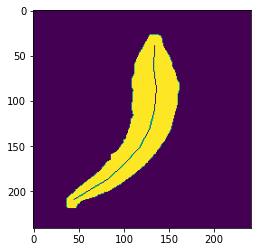

In [44]:
s = 2186
img = pre_img(imgs[s])
sk = NT_skeleton_t(imgs[s])
print(sk)
draw = img.copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

## find the pca

In [ ]:

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(han_sks)
pc1 = pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = pca.transform(han_sks)

pca_sks[s]

## apply the Kmeans

In [15]:
from sklearn.cluster import KMeans

n_clusters = 22
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-10, n_init=20)
kmeans.fit(pca_sks)
labels = kmeans.predict(pca_sks)
centers = kmeans.cluster_centers_

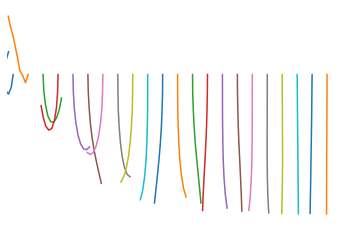

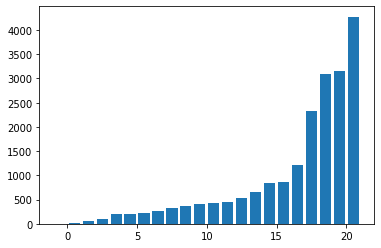

In [16]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()

0


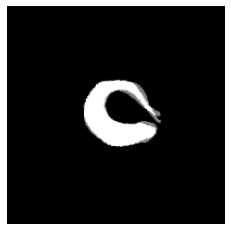

1


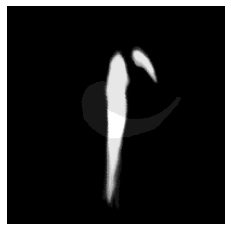

2


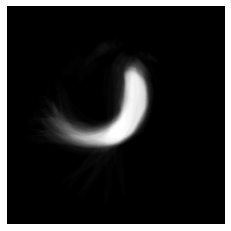

3


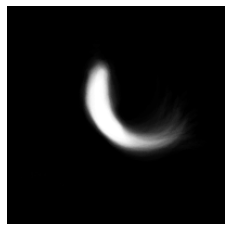

4


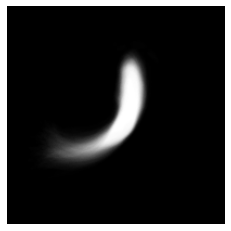

5


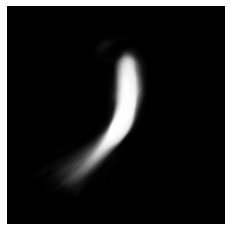

6


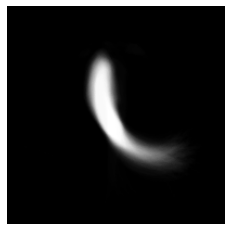

7


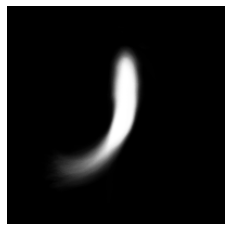

8


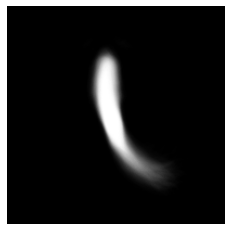

9


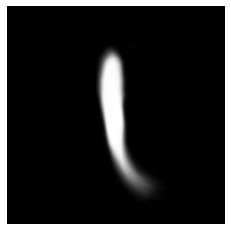

10


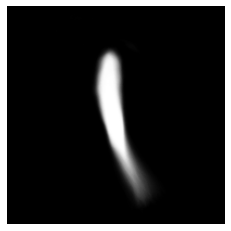

11


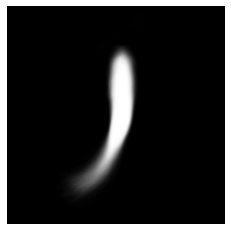

12


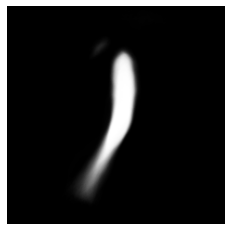

13


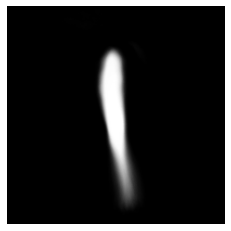

14


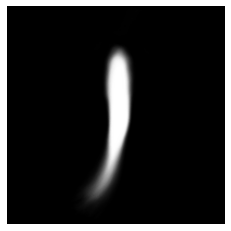

15


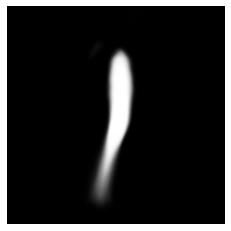

16


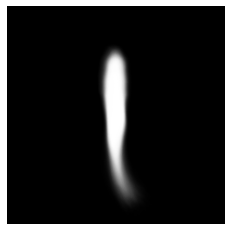

17


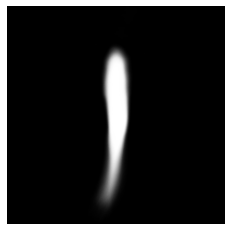

18


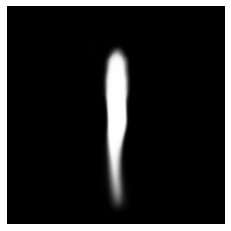

19


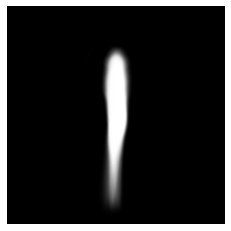

20


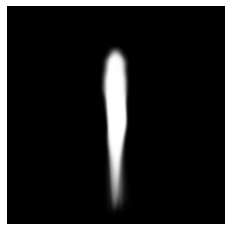

21


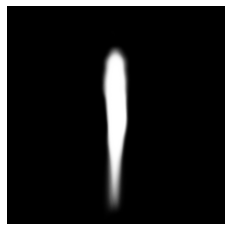

In [17]:
cen_imgs = np.zeros((n_clusters, 201, 201), dtype='int')
for s, label in enumerate(labels[:len(imgs)]):
    cen_imgs[label] += imgs[s]
for s, img in enumerate(cen_imgs[ords]):
    cen_imgs[s] = (img/nums[ords[s]]).astype('uint8')
    print(s)
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    plt.imshow(cen_imgs[s], plt.cm.gray)
    plt.axis('off')
    plt.show()

In [18]:
_, bins = np.histogram(np.abs(h_ans))
dic_ans = np.digitize(np.abs(h_ans), bins)

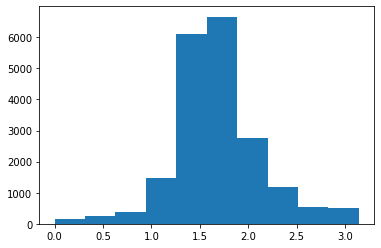

In [19]:
_ = plt.hist(np.abs(h_ans))

# 用 pca + angle 做kmeans

In [20]:
%%time
from sklearn.cluster import KMeans


merge_arr = np.concatenate((np.expand_dims(h_ans, axis=1), pca_sks), axis=1)
n_clusters = 150
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-11, n_init=20)
kmeans.fit(merge_arr)
labels = kmeans.predict(merge_arr)
centers = kmeans.cluster_centers_


CPU times: user 7min 2s, sys: 5min, total: 12min 2s
Wall time: 1min 32s


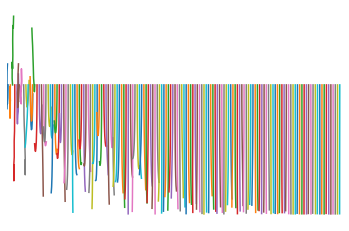

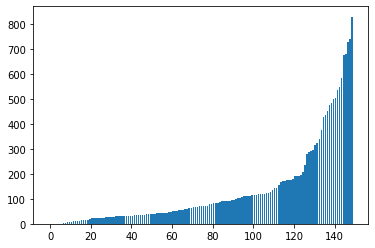

Text(0.5, 0, 'angle')

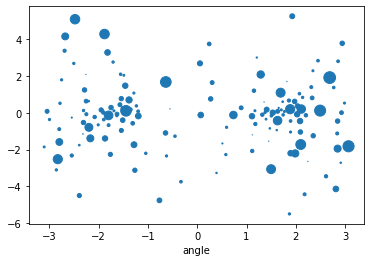

In [21]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas[1:], pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1

plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()

plt.scatter(*centers[ords][:,0:2].T, marker="o", s=nums/6)
plt.xlabel("angle")

# 產生對應的side view

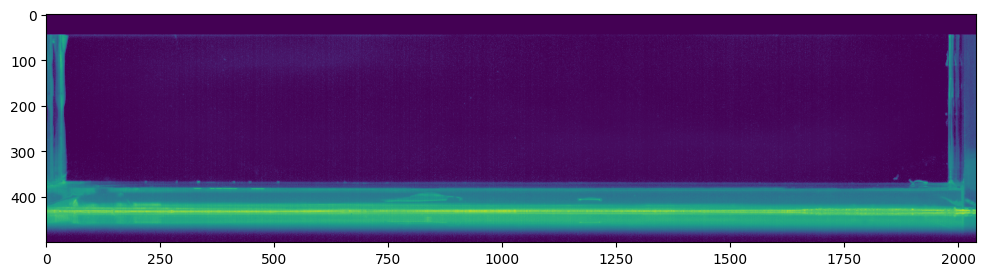

In [22]:
tnum = np.random.randint(data_len,size = int(data_len*0.2))
a = np.load(os.path.join(imgspath, flist[10]))
side_back = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s]))
    side_back += a
side_back = side_back/len(tnum)
side_back = side_back.astype('uint8')
plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(side_back)

aq_mask = np.full(a.shape, True)
aq_mask[0:45, ...] = False
plt.imshow(side_back*aq_mask)
aq_mask = np.where(aq_mask, 255, 0).astype('uint8')


-0.6


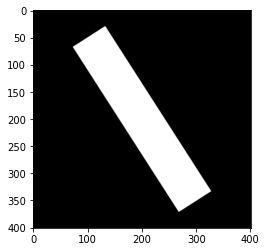

In [23]:

stand = np.zeros((401, 401, 3), dtype=np.uint8)
cv2.rectangle(stand, (20, 165), (380, 235), (255,255,255), -1)
M = cv2.getRotationMatrix2D((200, 200), (1)/(np.pi)*180, 1)
rotated = cv2.warpAffine(stand, M, (401,401))
stands = []
rot_an = []
level_lim = 50
for s in range(level_lim):
    an = (-1+(2*s/level_lim))
    M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
    stands.append(cv2.warpAffine(stand, M, (401,401)))
    rot_an.append(an)
plt.imshow(stands[10])
print(rot_an[10])

M = cv2.getRotationMatrix2D((200, 200), -rot_an[0]/(np.pi)*180, 1)
plt.imshow(cv2.warpAffine(stands[0], M, (401,401)))
plt.imshow(stands[0])

In [24]:
# sideviews = []
# kernel = np.ones((3,3), np.uint8)
    
# for s in tqdm(range(data_len)):
#     raw = np.load(os.path.join(imgspath, flist[s]))
#     a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2GRAY)
#     diff = ((cv2.absdiff(a, side_back)>25)*255).astype('uint8')
#     diff = cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
#     diff = cv2.erode(diff, kernel, iterations = 7)
#     diff = cv2.dilate(diff, kernel, iterations = 10)
    
#     a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2RGB)
#     side = cv2.bitwise_and(a, a, mask = diff)#apply mask
#     img = cutting_img(side, get_pos(diff), size = 200)
    
#     bacis = []
#     for num, stand in enumerate(stands):
#         bacis.append(np.sum(np.logical_and(img ,stand)))
#     bigarg = np.argmax(bacis)
#     an = -rot_an[bigarg]
#     M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
#     img = cv2.warpAffine(img, M, (401,401))

#     sideviews.append(img)
    

# #cv2.imwrite("test.png", diff)

## multi ver

In [25]:
%%time
from multiprocessing import Pool
from numba import jit, njit

@jit(nogil=True)
def muti_img(filepath, mask=aq_mask, stands=stands, kernel=np.ones((3,3), np.uint8), rot_an=rot_an):
    
    raw = np.load(filepath)
    a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2GRAY)
    diff = ((cv2.absdiff(a, side_back)>25)*255).astype('uint8')
    diff = cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
    diff = cv2.erode(diff, kernel, iterations = 1)
    diff = cv2.dilate(diff, kernel, iterations = 7)
    diff = cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
    
    a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2RGB)
    side = cv2.bitwise_and(a, a, mask = diff)#apply mask
    img = cutting_img(side, get_pos(diff), size = 200)
    
    bacis = [0]*len(stands)
    for num, stand in enumerate(stands):
        bacis[num] = np.sum(np.logical_and(img ,stand))
    bigarg = np.argmax(bacis)
    an = -rot_an[bigarg]
    M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
    if bacis[bigarg] > 20000:
        img = cv2.warpAffine(img, M, (401,401))
    
#     bacis = [0]*len(stands)
#     for num, stand in enumerate(stands):
#         bacis[num] = np.sum(np.logical_and(img ,stand))
#     bigarg = np.argmax(bacis)
#     an = -rot_an[bigarg]
#     M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
#     img = cv2.warpAffine(img, M, (401,401))
    
    return img

with Pool() as pool:
    map_arr = []
    for s in range(data_len):
        path = os.path.join(imgspath, flist[s])
        map_arr.append(path)
    print("pool start")
    result = pool.map(muti_img, map_arr, chunksize=20)
sideviews = result

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>



pool start


<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object m

<timed exec>:4: NumbaWarning: Code running in object mode won't allow parallel execution despite nogil=True.
/home/isis0517/.local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "muti_img" was compiled in object mode without forceobj=True.

File "<timed exec>", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/isis0517/.local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<timed exec>", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaDeprecationWarning(msg,
<timed exec>:4: NumbaWarning: Code running in object mode won't allow parallel exec

CPU times: user 39.2 s, sys: 19.7 s, total: 58.9 s
Wall time: 2min 46s


20000


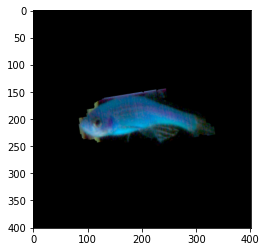

In [26]:

print(len(result))
img = result[6073]

plt.imshow(img)
plt.show()

np.savez("0421-sideviews.npz", sideviews)

In [27]:
class SortSearch:
    def __init__(self, arr):
        self.ords = np.lexsort(arr.T[::-1], axis=-1)
        self.sort_arr = arr[self.ords]
        self.length = len(arr)
        self.inv_ords = np.zeros(self.length, dtype=np.int)
        self.inv_ords[self.ords] = np.arange(self.length, dtype=np.int)
    def find_floor(self, item) -> (int, np.ndarray):
        pass
    def search(self, item, lower=0, upper=None) -> int:
        if upper is None:
            upper = self.length
        item = np.array(item)
        while upper-lower>1:
#             print(f"lower : {lower}, upper : {upper}")
            mid = (lower+upper+1)//2
            com = np.array(self.sort_arr[mid])
            big = item > com
            sma = item < com
            if np.sum(np.logical_xor(big, sma)) == 0:
                upper = mid
                lower = mid
            
            for s in range(len(item)):
                if big[s]:
                    lower = mid
                    break
                elif sma[s]:
                    upper = mid
                    break
            #print(upper, lower)
        return self.ords[lower]
                    
            

## set angle range 

In [28]:
an_mask = np.where(np.logical_and(np.abs(h_ans)>1.2, np.abs(h_ans)<2), 1, 0)
print(an_mask[15240])
merge_arr = np.concatenate((np.expand_dims(an_mask, axis=1), pca_sks), axis=1)
sorter = SortSearch(merge_arr)
print(sorter.ords[:10])
print(sorter.inv_ords[sorter.ords])

0
[ 5327  8508 12456  1578  5648  5464  1474 12460 19264 13471]
[    0     1     2 ... 19997 19998 19999]


<ipython-input-27-7d10fef3e848>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.inv_ords = np.zeros(self.length, dtype=np.int)
<ipython-input-27-7d10fef3e848>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in 

In [29]:
print(sorter.sort_arr[:10])

[[ 0.00000000e+00 -5.55574674e+00 -1.87928363e+00 -9.93682410e-01
  -1.32685993e-01 -4.28818765e-01]
 [ 0.00000000e+00 -5.39908337e+00 -8.90269239e-01  5.48504867e-02
   7.41001512e-02  3.05297954e-02]
 [ 0.00000000e+00 -5.39673547e+00 -3.25228806e-01 -3.09391362e-02
  -2.91113224e-03  8.48737531e-02]
 [ 0.00000000e+00 -5.15427616e+00 -1.45935679e-01  1.84695605e-01
  -7.12543604e-02  1.21041529e-01]
 [ 0.00000000e+00 -4.79347515e+00 -4.77055511e-03  9.84060068e-03
  -4.90880315e-02 -1.14129600e-01]
 [ 0.00000000e+00 -4.79267696e+00 -4.87059441e-01 -8.19715400e-02
  -1.55640845e-01 -8.58567407e-02]
 [ 0.00000000e+00 -4.77801048e+00 -7.05900816e-01  8.60314963e-02
  -1.01675928e-01 -7.41462308e-02]
 [ 0.00000000e+00 -4.75863815e+00 -3.52266419e-01  2.99796021e-01
  -1.16926227e-01 -7.66334879e-02]
 [ 0.00000000e+00 -4.71540575e+00 -1.60462039e-01 -1.85580839e-02
  -3.70540684e-02 -2.04567838e-02]
 [ 0.00000000e+00 -4.70486845e+00 -2.02329676e-01  2.23701811e-02
  -6.26979289e-02 -1.6545

# 用 sideview 對應出各個 kmeans center

In [30]:
#%%time
merge_arr = np.concatenate((np.expand_dims(h_ans, axis=1), pca_sks), axis=1)

cen_inds = []

cen_set =  {s:[] for s in range(n_clusters)}
    
for s, label in enumerate(labels):
    cen = centers[label]
    arr = merge_arr[s]
    dis = np.linalg.norm(arr-cen)
    cen_set[label].append((s, dis))
    
for s in range(n_clusters):
    cen_set[s].sort(key=lambda x: x[1])
    
cen_inds = [cen_set[s][0][0] for s in range(n_clusters)]
print(cen_inds[:10])
#ind = 177

class ImgGetor:
    def __init__(self, cen_set, B=1):
        
        for s in range(len(cen_set)):
            cen_set[s].sort(key=lambda x: x[1])
        self.cen_set = cen_set.copy()
        self.cen_probs = []
        self.cen_Qs = []
        for sett in self.cen_set.values():
            Q = 0
            #print(sett)
            length = 10 if len(sett) > 10 else len(sett)
            probs = []
            for s in range(length):
                P = np.exp(-B*(sett[s][1]))
                Q += P
                probs.append((sett[s][0], P))
            self.cen_probs.append(probs)
            self.cen_Qs.append(Q)
    
    def label2img(self, label, rat=1):
        if rat>=1 or rat<0:
            #print("error")
            rat = rat=np.random.rand()
        #print(rat)
        rat = rat*self.cen_Qs[label]
        CP = 0
        for s in self.cen_probs[label]:
            CP += s[1]
            ind = s[0]
            
            if CP > rat:
                break
        #print(self.cen_probs[label])
        return ind
        
geter = ImgGetor(cen_set, B=120)
print(geter.label2img(1))

[13683, 8465, 14656, 12847, 17194, 5489, 1922, 16156, 1006, 6486]
8465


In [31]:
video = cv2.VideoWriter("output_v.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, (sideviews[0].shape[1], sideviews[0].shape[0]))
for label in labels[:3000]:
    ind = geter.label2img(label)
    img = sideviews[ind].copy()
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
video.release()

# load the other vidoe

this data is hard to get the posture 

['frame_0.npy', 'frame_1.npy', 'frame_2.npy', 'frame_3.npy', 'frame_4.npy', 'frame_5.npy', 'frame_6.npy', 'frame_7.npy', 'frame_8.npy', 'frame_9.npy', 'frame_10.npy', 'frame_11.npy', 'frame_12.npy', 'frame_13.npy', 'frame_14.npy', 'frame_15.npy', 'frame_16.npy', 'frame_17.npy', 'frame_18.npy', 'frame_19.npy']


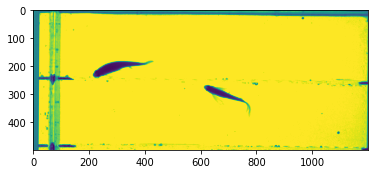

In [32]:
path2 = r"/media/isis0517/QVO2/0419/FaMb1/npy"
flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(temlist[:20])
flist2 = temlist
a = np.load(os.path.join(path2,flist2[0]))
plt.imshow(a)

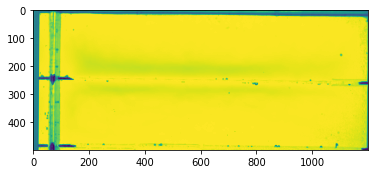

In [33]:

new_background = np.zeros(a.shape)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.3))
for s in tnum:
    a = np.load(os.path.join(path2, flist2[s]))
    new_background += a
    
new_background = new_background/len(tnum)
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

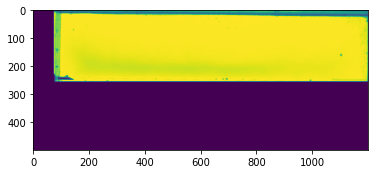

In [34]:
new_mask = np.full(new_background.shape, False)
new_mask[:255, 75:] = True
plt.imshow(new_background*new_mask)

100%|██████████| 15000/15000 [02:46<00:00, 89.95it/s]


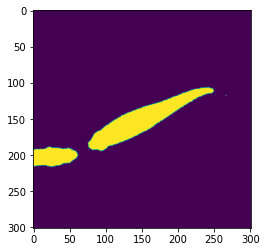

In [35]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)

new_imgs = []
new_h_ans = []
new_poses = []
new_han_sks = []
for filename in tqdm(flist2[:]):
    img = np.load(os.path.join(path2, filename))
    img = cv2.absdiff(new_background, img)
    img = np.where(img>80, 255, 0).astype('uint8')
    pos = get_pos(img)
    new_poses.append(pos)
    img = cutting_img(img, pos, 150)
    
    try:
        sk = NT_skeleton(img, er_num=4, di_num=5)
    except Exception as e:
        print(s, e)
        continue
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([-1,0]) # this is the baseline vector
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    h_an = angle
    M = cv2.getRotationMatrix2D((150, 150), 180+h_an/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (301,301))

    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(filename, vec_sk)
            draw = img.copy()
            cv2.circle(draw, (sk[0, 1], sk[0, 0]), 2, (0), -1)
            for n in range(len(sk)-1):
                cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
            plt.imshow(draw)
            plt.show()
            continue
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)   
    new_h_ans.append(-h_an)
    new_imgs.append(rotated)
    new_han_sks.append(han_sk)
    
    
plt.imshow(rotated)

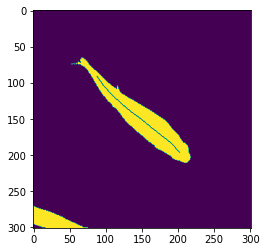

In [36]:
s = 11603
img = np.load(os.path.join(path2, flist2[s]))
img = cv2.absdiff(new_background, img)
img = np.where(img>60, 255, 0).astype('uint8')
pos = get_pos(img)
new_poses.append(pos)
img = cutting_img(img, pos, 150)
sk = NT_skeleton(img, er_num=5, di_num=4)

draw = img.copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
    
vec_sk = []
for i in range(len(sk)-1):
    vec_sk.append(sk[i+1]-sk[i])

heading = vec_sk[0]
han_sk=[]

heading = heading/np.linalg.norm(heading)
for vec in vec_sk[1:]:
    vec = vec/np.linalg.norm(vec)
    a = heading
    b = vec

    #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if angle != angle:
        print("算錯啦")
        print(filename, vec_sk)
        draw = imgs.copy()
        for n in range(len(sk)-1):
            cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
        plt.imshow(draw)
        continue
    err = a-np.dot(b, get_rot_M(angle))
    if np.linalg.norm(err) > 0.1:
        #print("turning", a, np.dot(b, get_rot_M(-angle)))
        angle=-angle
    han_sk.append(angle)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))


In [37]:
# def an2vec(an, r):
#     x = np.cos(an)
#     y = np.sin(an)
#     return r*np.array([x,y])

# def get_rot_M(angle):
#     a = np.cos(angle)
#     b = np.sin(angle)
#     return np.array([[a,-b],[b,a]])

# def an2ori(an_sk, vec=np.array([0,1]), intens=1):
#     test_sk = [vec]
#     for i in range(len(an_sk)):
#         vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
#         test_sk.append(test_sk[-1]+vec)

#     return np.array(test_sk)



# new_han_sks=[]

# for s, img in enumerate(tqdm(new_imgs)):
    
#     sk = NT_skeleton(img)
    
#     vec_sk = []
#     for i in range(len(sk)-1):
#         vec_sk.append(sk[i+1]-sk[i])
#     if len(sk)<10:
#         plt.imshow(img)
#         print(s, sk)
#         draw = img.copy()
#         for n in range(len(sk)-1):
#             cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
#         plt.imshow(draw)
#         plt.show()
    
#     heading = vec_sk[0]
#     han_sk=[]
    
#     heading = heading/np.linalg.norm(heading)
#     for vec in vec_sk[1:]:
#         vec = vec/np.linalg.norm(vec)
#         a = heading
#         b = vec

#         #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
#         #sin(angle) = a[1]b[0]-a[0]b[1]
#         c = a-b
#         angle = 2*np.arcsin(np.linalg.norm(c/2))
#         if angle != angle:
#             print("算錯啦")
#             print(s, vec_sk)
#         err = a-np.dot(b, get_rot_M(angle))
#         if np.linalg.norm(err) > 0.1:
#             #print("turning", a, np.dot(b, get_rot_M(-angle)))
#             angle=-angle
#         han_sk.append(angle)
#     n+=1
#     new_han_sks.append(han_sk)
# print(len(new_han_sks))    

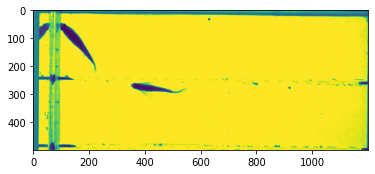

In [38]:
s = 2981
img = np.load(os.path.join(path2, flist2[s]))
plt.imshow(img)

In [39]:
#%%time
new_pca_sks = pca.transform(new_han_sks)
new_merge_arr = np.concatenate((np.expand_dims(new_h_ans, axis=1), new_pca_sks), axis=1)
new_labels = kmeans.predict(new_merge_arr)
back = np.zeros((side_back.shape[0], side_back.shape[1], 3), dtype='uint8')
geter = ImgGetor(cen_set, B=6000)

video = cv2.VideoWriter("output_new.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, (side_back.shape[1], side_back.shape[0]))

for s in range(30):
    img = np.full((side_back.shape[0], side_back.shape[1], 3), 255, dtype='uint8')
    #print(img.shape)
    video.write(img)

video_poses = []
    
rand_ints = np.random.rand(len(new_labels))
for s, label in enumerate(tqdm(new_labels)):
    ind = geter.label2img(label, rat=rand_ints[s])
    img = sideviews[ind].copy()
    pos = (200, int((new_poses[s][1]/new_background.shape[1])*side_back.shape[1]//10*8 + 100 ))
    img = glue_img(img, pos, back)
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
    video_poses.append(pos)
    
    
for s in range(30):
    img = np.full((side_back.shape[0], side_back.shape[1], 3), 255, dtype='uint8')
    #print(img.shape)
    video.write(img)
    
video.release()

np.save("video_poses", video_poses)
print(len(set(new_labels)))

100%|██████████| 15000/15000 [01:22<00:00, 181.87it/s]


133


## red dot ver

In [40]:
#%%time
#new_pca_sks = pca.transform(new_han_sks)
#new_merge_arr = np.concatenate((np.expand_dims(new_h_ans, axis=1), new_pca_sks), axis=1)
#new_labels = kmeans.predict(new_merge_arr)
back = np.zeros((side_back.shape[0], side_back.shape[1], 3), dtype='uint8')
#geter = ImgGetor(cen_set, B=6000)

video = cv2.VideoWriter("output_red.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, (side_back.shape[1], side_back.shape[0]))

for s in range(30):
    img = np.full((side_back.shape[0], side_back.shape[1], 3), 255, dtype='uint8')
    #print(img.shape)
    video.write(img)

video_poses = []
    
for s, label in enumerate(new_h_ans):
    
    img = np.zeros(back.shape, dtype='uint8')
    pos = (200, int((new_poses[s][1]/new_background.shape[1])*side_back.shape[1]//10*8 + 100 ))
    img = cv2.circle(img, (pos[1], pos[0]), 30, (10, 10, 180), -1)
    img = cv2.putText(img, f"{s}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
    video_poses.append(pos)
    
    
for s in range(30):
    img = np.full((side_back.shape[0], side_back.shape[1], 3), 255, dtype='uint8')
    #print(img.shape)
    video.write(img)
    
video.release()

np.save("video_poses", video_poses)

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

/home/isis0517/.local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "muti_img" was compiled in object mode without forceobj=True.

File "<timed exec>", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/isis0517/.local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit



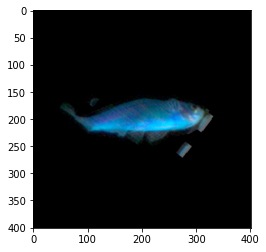

In [41]:
plt.imshow(np.load(os.path.join(imgspath, flist[8759])))
img = muti_img(os.path.join(imgspath, flist[8759]))
plt.imshow(img)
np.save("video_poses", video_poses)


# another vidoe

23430


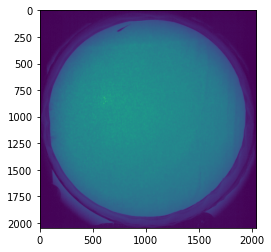

In [42]:
path2 = r"/media/isis0517/QVO2/0115/03"

flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(temlist))
flist2 = temlist[:-100]
img = np.load(os.path.join(path2,flist2[0]))
#img = (img/255)**0.6*255
plt.imshow(img)

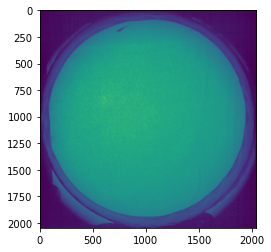

In [43]:
gamma = 0.7
lookUpTable = np.empty((1,256), np.uint8)
for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
res = cv2.LUT(img, lookUpTable)
plt.imshow(res)

<ipython-input-44-5296ac9fe7a7>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new_background = np.zeros(img.shape, dtype=np.float)
100%|██████████| 4666/4666 [01:21<00:00, 57.59it/s]


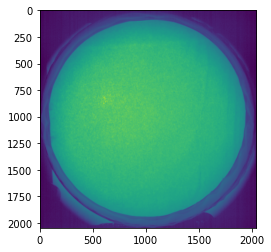

In [44]:
new_background = np.zeros(img.shape, dtype=np.float)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.2))
for s in tqdm(tnum):
    img = np.load(os.path.join(path2, flist2[s]))
    img = cv2.LUT(img, lookUpTable)
    img = cv2.blur(img, (5, 5))
    new_background += img
    
new_background = new_background / len(tnum)
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

100%|██████████| 23330/23330 [16:12<00:00, 24.00it/s]


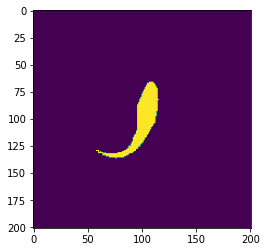

In [45]:
new_imgs = []
for filename in tqdm(flist2):
    img = np.load(os.path.join(path2, filename))
    img = cv2.LUT(img, lookUpTable)
    img = img.astype(np.uint8)
    img = cv2.blur(img, (5, 5))
    img = cv2.absdiff(new_background, img)
    img = np.where(img>30, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, 100)
    new_imgs.append(img)
plt.imshow(img)

In [46]:
now_roteds = []
new_h_ans = []

for img in tqdm(new_imgs):
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (201,201))
    
    now_roteds.append(rotated)
    new_h_ans.append(angle)

100%|██████████| 23330/23330 [01:01<00:00, 379.43it/s]


In [47]:

new_han_sks=[]

for s, img in enumerate(tqdm(now_roteds)):
    
    sk = NT_skeleton(img, di_num=5)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print(s, NT_skeleton(imgs[s]))
        plt.show()
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    n+=1
    new_han_sks.append(han_sk)
print(len(new_han_sks))    


100%|██████████| 23330/23330 [01:19<00:00, 294.44it/s]

23330


In [48]:
new_pca_sks = pca.transform(new_han_sks)
new_merge_sks = np.concatenate((np.ones((len(new_pca_sks),1)), new_pca_sks), axis=1)
sorter.search(new_merge_sks[0])

15997

In [49]:
video = cv2.VideoWriter("output_v.avi", 0, 30, (sideviews[0].shape[1], sideviews[0].shape[0]))
for sks in tqdm(new_merge_sks[:3000]):
    ind = sorter.search(sks)
    if ind == 18483:
        print(sks, merge_arr[18483])
        break
    img = sideviews[ind].copy()
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
video.release()

100%|██████████| 3000/3000 [00:01<00:00, 2410.63it/s]


# t-sne

In [50]:

%%time
loadding = np.load("0419-sideviews.npz")

sideviews = loadding["arr_0"]

from sklearn import manifold

X = [cv2.cvtColor(x, cv2.COLOR_RGB2GRAY).flatten() for x in sideviews]
Tsne = manifold.TSNE(n_components=2, init='random', verbose=2)
t_lables = Tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 1.514s...
[t-SNE] Computed neighbors for 20000 samples in 478.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

In [51]:
#plt.scatter(*t_lables.T, s=0.1)

arr = []

for s, label in enumerate(t_lables):
    if label[0]<72 and label[0]>71 and label[1]<-37 and label[1]>-38:
        arr.append(s)
        print(s)
        plt.imshow(sideviews[s])
        plt.show()
print(t_lables[8759])

[61.849335 24.435644]
